# Importing packages

In [1]:
import segyio
import numpy as np
import pandas as pd
import missingno as msno
import pickle as pkl
import matplotlib.pyplot as plt
import time
from shutil import copyfile
import os

# Defining functions to use in the future

In [2]:
def reshape_df(np_series, column_name):
    np_series = np_series.reshape(-1, np_series.shape[-1])
    df_reshaped = pd.DataFrame(np_series)
    df_reshaped = df_reshaped.values.reshape(-1, 1)
    df_reshaped = pd.DataFrame(df_reshaped, columns=[column_name])
    return df_reshaped

In [3]:
def get_qube_data(seis_path):
    seismic_data = segyio.tools.cube(seis_path)
    with segyio.open(seis_path, "r") as segyfile:
        # Read the seismic data
        # Get the original SEGY file specifications
        spec = segyio.tools.metadata(segyfile)
        
        # seismic_data = segyfile.trace.raw[:]
        return seismic_data, spec

In [4]:
def write_segy(base_segy_path, result_segy_data, date_time_str):
    '''
    Writes result_segy_data to a segy-file (result_segy_path) with same header/size as base_segy_path

    Args:
        result_segy_path:
        base_segy_path:
        result_segy_data:

    Returns:
    '''

    # Select last channel
    #if type(result_segy_data) is list:
        #result_segy_data = result_segy_data[-1]

    
    result_folder_path = os.path.join(os.path.curdir, "05.Predictions",  date_time_str)
    try:
        os.mkdir(r"./05.Predictions")
    except FileExistsError:
        pass
    
    try:    
        os.mkdir(result_folder_path)
    except FileExistsError:
        pass          

    result_segy_path = os.path.join(result_folder_path, "Prediction.sgy")
    
    print("Writing interpretation to " + result_segy_path)

    copyfile(base_segy_path, result_segy_path)

    # Moving temporal axis back again
    #result_segy_data = np.moveaxis(result_segy_data, 0, -1)

    # Open out-file
    with segyio.open(result_segy_path, "r+") as result_segy:
        iline_start = result_segy.ilines[0]
        dtype = result_segy.iline[iline_start].dtype
        # loop through inlines and insert output
        for i in result_segy.ilines:
            iline = result_segy_data[i - iline_start, :, :]
            result_segy.iline[i] = np.ascontiguousarray(iline.astype(dtype))

    # TODO: rewrite this whole function
    # Moving temporal axis first again - just in case the user want to keep working on it
    #result_segy_data = np.moveaxis(result_segy_data, -1, 0)

    print("Writing interpretation - Finished")
    return

# ==============================================================

# ==============================================================

# ==============================================================

# Loadning Data

In [5]:
date_time_str = time.strftime("run_%Y_%m_%d-%H_%M_%S")

### Preparing data for prediction

In [6]:
amp_path = r".\04.SeismicQubes\KP106_depth_ML [Realized] 1"
density_path = r".\04.SeismicQubes\KP106_density_depth_ML [Realized] 1"
imped_path = r".\04.SeismicQubes\KP106_P_impedans_depth_ML [Realized] 1"
vpvs_path = r".\04.SeismicQubes\KP106_VpVs_depth_ML [Realized] 1"

In [7]:
amp_data = segyio.tools.cube(amp_path) 
dens_data = segyio.tools.cube(density_path)
imped_data = segyio.tools.cube(imped_path)
vpvs_data = segyio.tools.cube(vpvs_path)

In [8]:
amp_df = reshape_df(amp_data, "KP106_DEPTH_ML_REALIZED_1")
dens_df = reshape_df(dens_data, "KP106_DENSITY_DEPTH_ML_REALIZED_1")
imped_df = reshape_df(imped_data, "KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1")
vpvs_df = reshape_df(vpvs_data, "KP106_VPVS_DEPTH_ML_REALIZED_1")
sint_gsr_data = pd.DataFrame(np.zeros(vpvs_df.shape), columns=["GSRQube_ForPred"])

In [9]:
data_df = pd.concat([amp_df, dens_df, imped_df, vpvs_df, sint_gsr_data], axis=1)

In [10]:
data_df

,KP106_DEPTH_ML_REALIZED_1,KP106_DENSITY_DEPTH_ML_REALIZED_1,KP106_P_IMPEDANS_DEPTH_ML_REALIZED_1,KP106_VPVS_DEPTH_ML_REALIZED_1,GSRQube_ForPred
0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...
52681771,-129.600449,2.555233,9337.382812,1.766267,0.0
52681772,-100.875763,2.556221,9109.242188,1.766458,0.0
52681773,-91.801224,2.559512,8946.664062,1.766328,0.0
52681774,-94.717545,2.567398,8850.367188,1.766364,0.0


# Predicting

In [11]:
prep_pipeline_path = r"F:\NewFolder\ANACONDA\00.Projects\00.ML_Coll_Pred\01. Hantos\03.Pad106\03.Pad106_НапрямуюСКубами\03.Models\run_2024_05_13-15_43_55\ColumnTransformer.pkl"
pred_model_path = r"F:\NewFolder\ANACONDA\00.Projects\00.ML_Coll_Pred\01. Hantos\03.Pad106\03.Pad106_НапрямуюСКубами\03.Models\run_2024_05_13-15_43_55\xgb_reg_stage1.pkl"

In [12]:
with open(prep_pipeline_path, "rb") as file:
    prep_pipeline = pkl.load(file)

In [13]:
with open(pred_model_path, "rb") as file:
    model = pkl.load(file)

In [14]:
prep_data = prep_pipeline.transform(data_df)

In [15]:
prep_data.shape

(52681776, 4)

In [16]:
prediction_result = model.predict(prep_data)

In [17]:
prediction_result.shape

(52681776,)

In [18]:
prediction_result_transformed = prediction_result.reshape(amp_data.shape)

In [19]:
prediction_result_transformed.shape

(336, 391, 401)

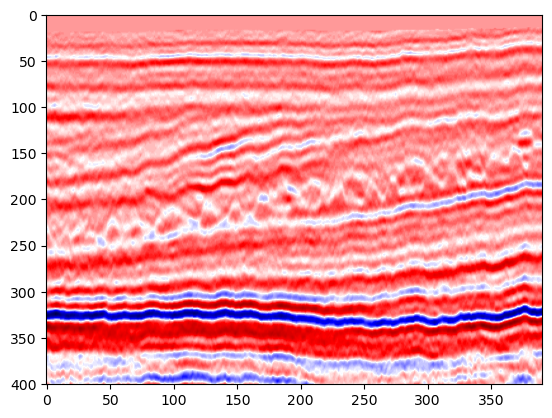

In [20]:
plt.imshow(amp_data[50, :, :].T, cmap="seismic", aspect='auto')

In [21]:
prediction_result_transformed.shape[0]

336

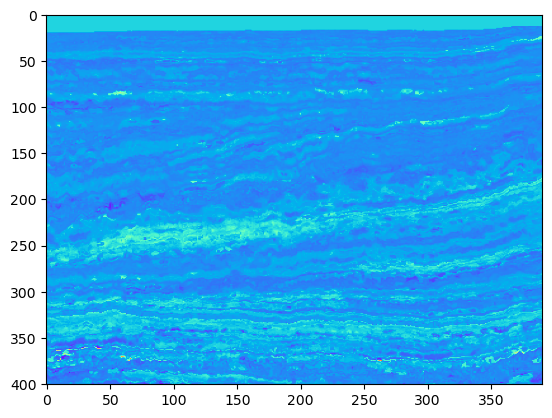

In [22]:
plt.imshow(prediction_result_transformed[10, :, :].T, cmap="rainbow", aspect='auto')

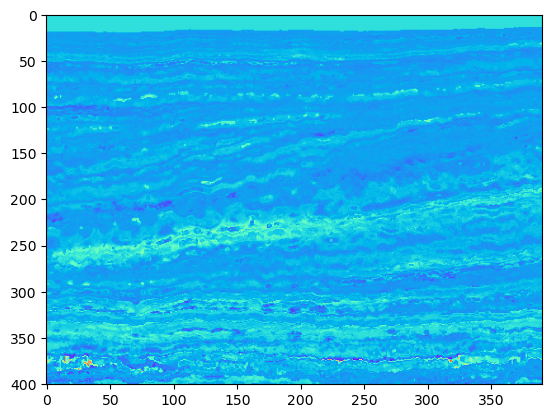

In [23]:
plt.imshow(prediction_result_transformed[60, :, :].T, cmap="rainbow", aspect='auto')

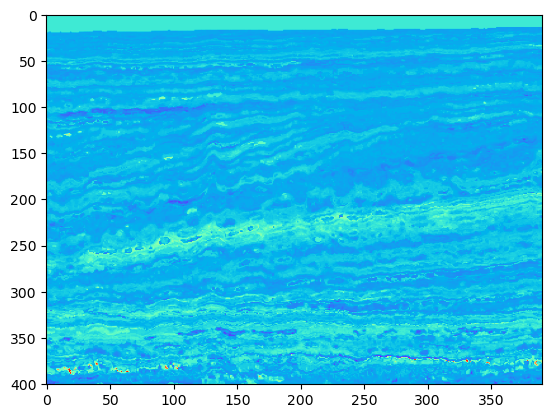

In [24]:
plt.imshow(prediction_result_transformed[110, :, :].T, cmap="rainbow", aspect='auto')

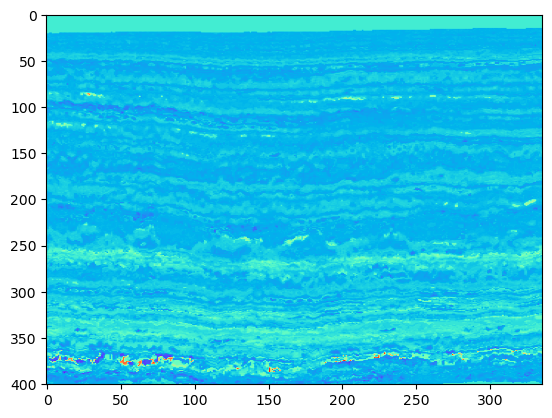

In [25]:
plt.imshow(prediction_result_transformed[:, 10, :].T, cmap="rainbow", aspect='auto')

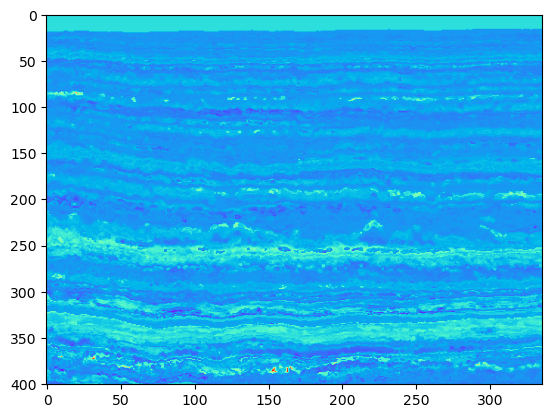

In [26]:
plt.imshow(prediction_result_transformed[:, 60, :].T, cmap="rainbow", aspect='auto')

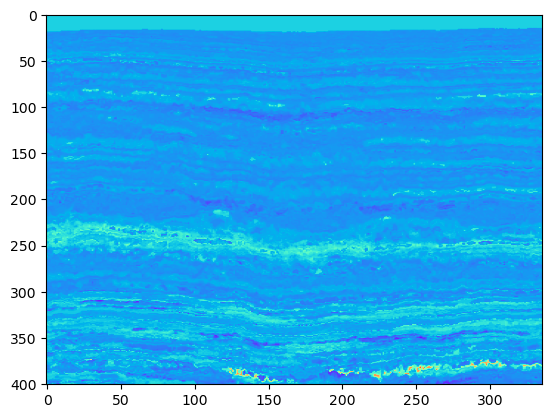

In [27]:
plt.imshow(prediction_result_transformed[:, 110, :].T, cmap="rainbow", aspect='auto')

In [ ]:
plt.imshow(prediction_result_transformed[:, :, 10].T, cmap="rainbow", aspect='auto')

In [ ]:
plt.imshow(prediction_result_transformed[:, 110, :].T, cmap="rainbow", aspect='auto')

In [ ]:
plt.imshow(prediction_result_transformed[:, 110, :].T, cmap="rainbow", aspect='auto')

In [23]:
write_segy(amp_path, prediction_result_transformed, date_time_str)

Writing interpretation to .\05.Predictions\run_2024_05_13-16_29_33\Prediction.sgy
Writing interpretation - Finished
